# Armita Bahrudi - 810100591

Artificial Intelligence - CA#03: *Hidden Markov Model* - fall 1402 \
In this notebook, we will implement a HMM algorithm to Sound Classification.

## Hidden Markov Model introduction

HMM is a statistical model that is used to describe the probabilistic relationship between a sequence of observations and a sequence of hidden states.

HMM is better suited for modeling phenomena that exhibit temporal dependencies and sequential patterns, such as speech recognition, handwriting recognition, gesture recognition, and activity recognition. HMMs can also be used in bio informatics for protein structure prediction and gene classification.

Advantages of HMM model:
1. HMMs can model complex temporal dependencies and sequential patterns.
2. HMMs can handle missing data and noisy data.
3. HMMs can be trained using unsupervised learning, which is useful when labeled data is not available.
4. HMMs are computationally efficient and can be used for real-time applications.

Disadvantages of HMM model:
1. HMMs assume that the system being modeled is a Markov process, which may not always be true.
2. HMMs require a large amount of training data to accurately model the underlying system.
3. HMMs may suffer from overfitting if the model is too complex or the training data is insufficient.
4. HMMs may not be able to capture long-term dependencies in the data.

### States in HMM

The states represent the hidden sequence that we are trying to predict. In this problem, it can be said that they show a kind of repeating pattern in music.

### Observations in HMM

Observations are the data that we can get from test and training samples.

For audio processing, we needed to find a way to concisely represent song waveforms. Mel Frequency Cepstral Coefficients (MFCC) is a good way to do this. MFCC takes the power spectrum of a signal and then uses a combination of filter banks and discrete cosine transform to extract features.

In this issue, we use ```First-Order HMM```. Which means that each state is only dependent on its previous state.

## Different types of HMM  

1. Gaussian HMMs: A statistical model that assumes the underlying system is a Markov process with hidden states, and the observations are generated from a Gaussian distribution.

2. Hidden semi-Markov models (HSMMs): A type of HMM where the duration of each state is modeled by a semi-Markov process, which allows for more flexible modeling of temporal dependencies.

3. Hierarchical HMMs: A hierarchical version of HMMs that allows for modeling of complex structures in the hidden states.

4. Coupled HMMs: A type of HMM that models multiple sequences simultaneously, allowing for dependencies between the sequences.

5. Switching state HMMs: A type of HMM where the transition probabilities between hidden states can change based on some external signal.

6. Recurrent neural network-based HMMs (RNN-HMMs): A combination of HMMs and recurrent neural networks, where the neural network is used to model the transition probabilities between hidden states.

7. Maximum entropy Markov models (MEMMs): A type of probabilistic model that uses maximum entropy to estimate the conditional probability distribution of the next state given the current state and observations.

8. Dynamic Bayesian networks (DBNs): A type of probabilistic graphical model that models temporal dependencies between variables using a directed acyclic graph.

### why in sound classification better to have sample in same size?

1. Simplified Frame-Based Processing: Uniform frame sizes streamline the division of the audio signal into frames.

2. Consistent State Transitions: Uniform frame sizes ensure that state transitions in the HMM align with consistent portions of the input data, simplifying the modeling process.

3. Smooth Feature Extraction: Uniform frame sizes facilitate consistent and predictable feature extraction, benefiting the parameterization and analysis of features such as MFCCs.

4. Streamlined Model Training: Uniform feature frames enable simpler and more consistent implementation of the HMM, enhancing the overall model training process.

5. Simplified State Duration Modeling: Consistent frame sizes simplify the process of modeling state durations, allowing for easier implementation of duration constraints.

6. Improved Alignment and Interpretation: Uniform frame sizes lead to more straightforward and consistent state transitions, alignments, and likelihood evaluations, facilitating better interpretation of HMM results.

### Why do the frames used in calculating MFCC overlap with each other?

Overlapping frames mean that each frame of audio data used for feature extraction includes some data from the previous frame and some from the subsequent frame. \
So overlapping frames provide a more robust representation of temporal changes in audio features, enhancing the effectiveness of MFCC computation.



### In most audio-related projects, why are 12 to 13 initial coefficients of MFCC used?

These coefficients can effectively model the properties of sound within the range of human hearing.


## First Part

In [12]:
import librosa
import numpy as np
import librosa.display
from hmmlearn import hmm
from sklearn import metrics
import matplotlib.pyplot as plt

In [13]:
GENRES = ['blues', 'hiphop', 'metal', 'pop']
NUM_SAMPLE_FOR_GENRES = 100
LOWER_NUM_OF_FRAME = 1290
COEFFICIENT_COUNT = 13
SAMPLES_FILE = 'data'
DATA_FOR_TRAIN = 0.8
COMPONENT_COUNT = 10
SAMPLE_COUNT = 100
GENRE_COUNT = 4


In [14]:
def make_address(genre):
    addresses = []
    for i in range(0, SAMPLE_COUNT):
        addresses.append(f'./{SAMPLES_FILE}/{genre}/{genre}.{i:05d}.wav')
    return addresses

def calc_mfcc(data_address, coeffidence_count):
    signal, sampling_rate =  librosa.load(data_address)
    mfccT = librosa.feature.mfcc(y=signal, sr=sampling_rate, n_mfcc=coeffidence_count)
    return mfccT.T

def calc_mfccs(GENRES, Transpose):
    mfccs = []
    for g in range(len(GENRES)):
        g_mfccs = []
        addresses = make_address(GENRES[g])
        for a in addresses:
            mfcc = calc_mfcc(a, COEFFICIENT_COUNT)
            if Transpose:
                g_mfccs.append(mfcc[0:LOWER_NUM_OF_FRAME])
            else:
                g_mfccs.append((mfcc[0:LOWER_NUM_OF_FRAME]).T)
        mfccs.append(g_mfccs)
    return mfccs 

def divide_mfccs(mfccs):
    train_mfccs = []
    test_mfccs = []
    for g in range(GENRE_COUNT):
        train_mfccs.append(mfccs[g][0:int(DATA_FOR_TRAIN * len(mfccs[g]))])
        test_mfccs.append(mfccs[g][int(DATA_FOR_TRAIN * len(mfccs[g])): len(mfccs[g])])
    return train_mfccs, test_mfccs

def print_heatmap(mfcc, genre):
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title(f'{genre.upper()} heatmap')
    plt.show()


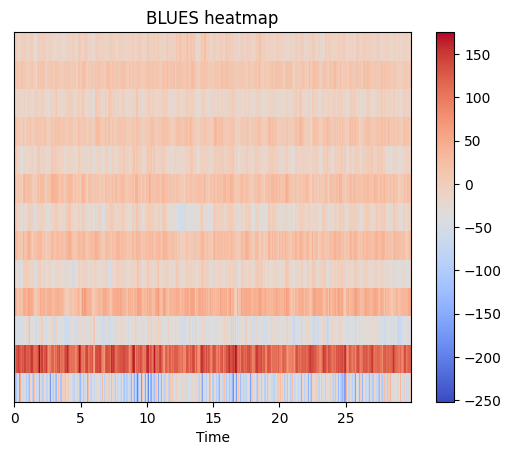

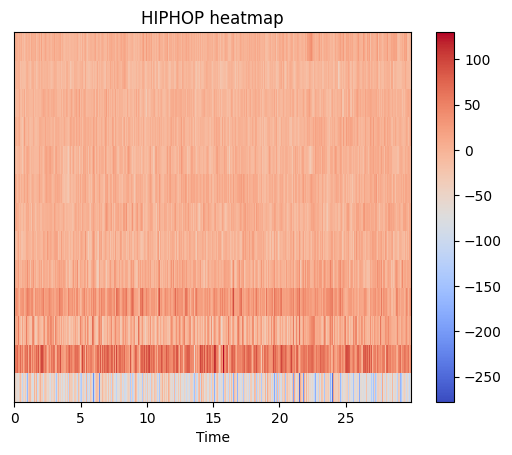

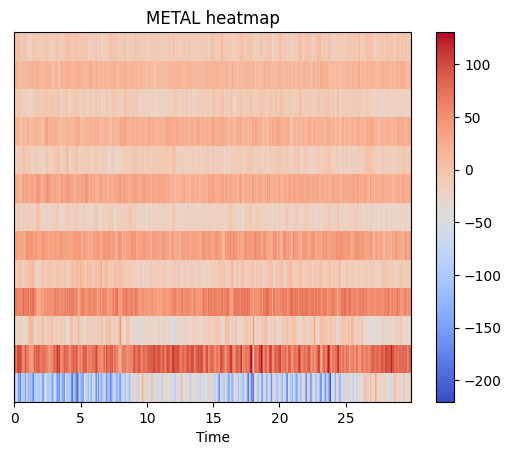

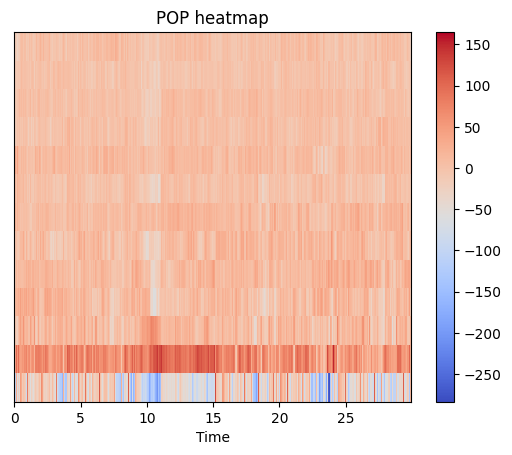

In [15]:
mfccs = calc_mfccs(GENRES, True)
train_mfccs , test_mfccs = divide_mfccs(mfccs)

for i in range(GENRE_COUNT):
   print_heatmap(test_mfccs[i][0].T, GENRES[i])

In [16]:
class HMMPredictor:
    def __init__(self):
        self.models = []
        self.true_genres = []
        self.pred_genres = []
        
    def train(self, mfccs):
        model = hmm.GaussianHMM(n_components = COMPONENT_COUNT)
        model.fit(mfccs,lengths=[LOWER_NUM_OF_FRAME ]* (int(DATA_FOR_TRAIN *NUM_SAMPLE_FOR_GENRES)))
        self.models.append(model)
    
    def predict_genre(self, input_data):
        probs = [model.score(input_data) for model in self.models]
        predicted_genre = GENRES[np.argmax(probs)]
        return predicted_genre
    
    def predict_all_tests(self, test_mfccs):
        for i in range(GENRE_COUNT):
            for mfcc in test_mfccs[i]:
                self.true_genres.append(GENRES[i])
                self.pred_genres.append(self.predict_genre(mfcc))

    def calc_accuracy(self, genres):
        accuracies = 4 * [None]
        for g in range(len(genres)):
            true_pred = 0
            for i in range(len(self.pred_genres)):
                if self.pred_genres[i] == genres[g] and self.true_genres[i] == genres[g]:
                    true_pred += 1
            accuracies[g] = (true_pred / ((1 - DATA_FOR_TRAIN) * NUM_SAMPLE_FOR_GENRES * GENRE_COUNT))
        return accuracies

    
    def show_prediction_result(self):
        cm = metrics.confusion_matrix(self.true_genres, self.pred_genres )
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GENRES)
        cm_display.plot()
        plt.title('result')
        plt.show()
        accuracies = self.calc_accuracy(GENRES)
        print(metrics.classification_report(self.true_genres, self.pred_genres, target_names=GENRES))
        print('accuracy for each class:')
        for g in range(GENRE_COUNT):
            print("                        ",GENRES[g], ':   ', accuracies[g])


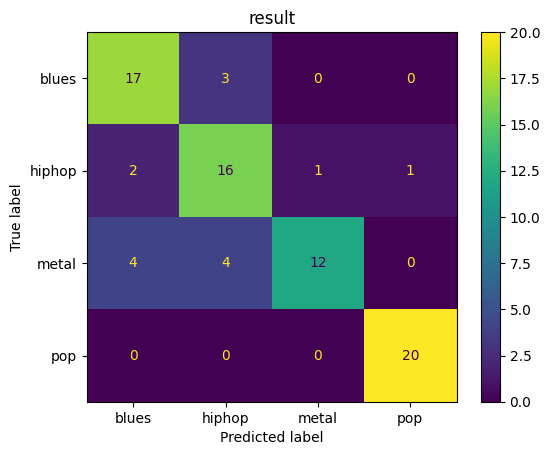

              precision    recall  f1-score   support

       blues       0.74      0.85      0.79        20
      hiphop       0.70      0.80      0.74        20
       metal       0.92      0.60      0.73        20
         pop       0.95      1.00      0.98        20

    accuracy                           0.81        80
   macro avg       0.83      0.81      0.81        80
weighted avg       0.83      0.81      0.81        80

accuracy for each class:
                         blues :    0.21250000000000005
                         hiphop :    0.20000000000000004
                         metal :    0.15000000000000002
                         pop :    0.25000000000000006


In [17]:
predictor = HMMPredictor()

for i in range(GENRE_COUNT):
    mfccs_genre = train_mfccs[i]
    predictor.train(np.vstack(mfccs_genre))
    
predictor.predict_all_tests(test_mfccs)
predictor.show_prediction_result()

### Evaluation Criteria

``Accuracy``: The accuracy measures the proportion of correctly classified instances among all instances. It is calculated by dividing the number of correctly classified instances by the total number of instances.

``Precision``: Precision measures the proportion of true positives (correctly predicted positive instances) among all predicted positive instances. It is calculated by dividing the number of true positives by the sum of true positives and false positives.

``Recall``: Recall measures the proportion of true positives among all actual positive instances. It is calculated by dividing the number of true positives by the sum of true positives and false negatives.

``F1 Score``: The F1 score is a weighted harmonic mean of precision and recall, where the emphasis is on balancing precision and recall. It is calculated as 2*(precision*recall)/(precision+recall).

### what is the difference between recall and precision? when shall we use one of them?

Ah, precision and recall, two fundamental concepts in the field of information retrieval and machine learning. Let's break it down!

### Precision:
Precision focuses on the relevance of the retrieved results. It is the ratio of relevant instances (true positives) to the total number of instances that were retrieved (true positives + false positives). In simpler terms, precision answers the question: "Of all the items we retrieved as relevant, how many are actually relevant?"

### Recall:
Recall, on the other hand, emphasizes the coverage of relevant results. It is the ratio of relevant instances that have been retrieved (true positives) to the total number of relevant instances in the dataset (true positives + false negatives). In simpler terms, recall answers the question: "Of all the relevant items in the dataset, how many did we retrieve?"

### When to Use Each:
The choice between precision and recall depends on the specific problem and its associated requirements:

- Precision becomes crucial when the cost of ``false positives is high``. For instance, in medical diagnosis, when identifying a disease, it's essential to have high precision to minimize false alarms.

- Recall, on the other hand, is more crucial when the c``ost of false negatives is high``. In scenarios such as search engines or information retrieval systems, recall is critical to ensure that most relevant items are retrieved, even if it means retrieving some irrelevant ones.

### what is difference between macro micro and weighted average?

- Macro-average: It calculates the metric for each class independently and then takes the average, treating all classes equally. It is beneficial when you want to assess the overall performance without being influenced by class imbalances.

- Micro-average: Involves aggregating the contributions of all classes to compute the average metric, treating each instance equally. It's useful when stressing the overall performance across all instances and minimizing the impact of class imbalances.

- Weighted average: It calculates the metric for each class and weighs the contributions of each class proportionally based on the number of true instances in each class, making it valuable when you need to balance the influence of each class's performance based on their representation in the dataset.

## Second Part

In [18]:
from sklearn.preprocessing import normalize
from scipy.stats import multivariate_normal
import numpy as np

In [23]:
GENRES = ['blues', 'hiphop', 'metal', 'pop']
NUM_SAMPLE_FOR_GENRES = 100
LOWER_NUM_OF_FRAME = 1290
COEFFICIENT_COUNT = 13
SAMPLES_FILE = 'data'
DATA_FOR_TRAIN = 0.96
COMPONENT_COUNT = 10
SAMPLE_COUNT = 100
GENRE_COUNT = 4

In [24]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:, t] = self.initial_prob[:, t] * observation_matrix[:, t]
            else:
                alpha[:, t] = np.dot(self.transition_matrix.T, alpha[:, t-1]) * observation_matrix[:, t]

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.dot(self.transition_matrix, (beta[:, t+1] * observation_matrix[:, t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T, self.mean[:, s], self.covariances[:, :, s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = self.transition_matrix * np.outer(alpha[:, t], (beta[:, t+1] * B[:, t+1].T))
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:, t] * beta[:, t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:, -1] * beta[:, -1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = gamma[:, 0][:, np.newaxis]
        expected_transition = self._stochasticize(xi_sum / np.sum(xi_sum, axis=1)[:, np.newaxis])

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


In [25]:
def calc_accuracy( genres, pred_genres, true_genres):
        accuracies = 4 * [None]
        for g in range(len(genres)):
            true_pred = 0
            for i in range(len(pred_genres)):
                if pred_genres[i] == genres[g] and true_genres[i] == genres[g]:
                    true_pred += 1
            accuracies[g] = (true_pred / ((1 - DATA_FOR_TRAIN) * NUM_SAMPLE_FOR_GENRES * GENRE_COUNT))
        return accuracies

def print_result(true_genres, pred_genres):
    cm = metrics.confusion_matrix(true_genres, pred_genres)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=GENRES)
    cm_display.plot()
    plt.title('Normalized result')
    plt.show()
    accuracies = calc_accuracy(GENRES, pred_genres, true_genres)
    print(metrics.classification_report(true_genres, pred_genres, target_names=GENRES))
    print('accuracy for each class:')
    for g in range(GENRE_COUNT):
        print("                       ",GENRES[g], ':   ', accuracies[g])
    
mfccs = calc_mfccs(GENRES, False)
train_mfccs , test_mfccs = divide_mfccs(mfccs)
hmm_models = [None] * 4

for i in range(GENRE_COUNT):
    hmm_models[i] = HMM(num_hidden_states = COMPONENT_COUNT)
    mfccs_genre = train_mfccs[i]
    for k in range(int( DATA_FOR_TRAIN * NUM_SAMPLE_FOR_GENRES)):
        normalized_train_mfcc = normalize(mfccs_genre[k], axis=1, norm='l2')
        hmm_models[i].train(normalized_train_mfcc)
    


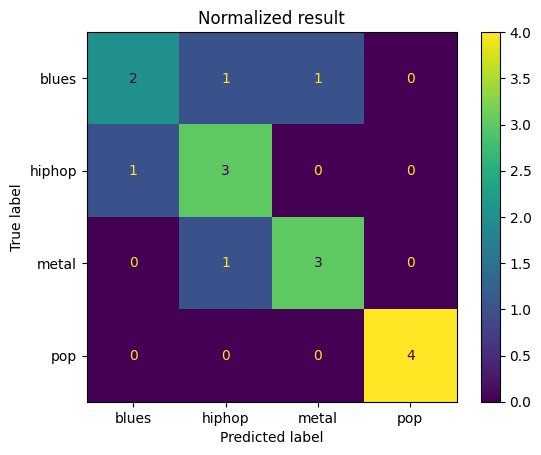

              precision    recall  f1-score   support

       blues       0.67      0.50      0.57         4
      hiphop       0.60      0.75      0.67         4
       metal       0.75      0.75      0.75         4
         pop       1.00      1.00      1.00         4

    accuracy                           0.75        16
   macro avg       0.75      0.75      0.75        16
weighted avg       0.75      0.75      0.75        16

accuracy for each class:
                        blues :    0.12499999999999989
                        hiphop :    0.18749999999999983
                        metal :    0.18749999999999983
                        pop :    0.24999999999999978


In [26]:
true_genres = []
pred_genres = []
for i in range(GENRE_COUNT):
    for mfcc in test_mfccs[i]:
        true_genres.append(GENRES[i])
        normalized_mfcc = normalize(mfcc, axis=1, norm='l2')
        probs = [model.score(normalized_mfcc) for model in hmm_models]
        predicted_genre = GENRES[np.argmax(probs)]
        pred_genres.append(predicted_genre)

print_result(true_genres, pred_genres)

Since the method of information extraction and pre-processing is the same in both models, the difference in answers is due to the difference in the implementation of the models. It can be said that actually our manual model has singular points and has not converged well to the answer. Because it works randomly better or worse depending on the amount of train data